In [1]:
from unseen import fileio
from unseen import spatial_selection

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import regionmask
import geopandas as gp
import xarray as xr
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

## Example region

In [2]:
regions = regionmask.defined_regions.srex
regions

<regionmask.Regions>
Name:     SREX
Source:   Seneviratne et al., 2012 (https://www.ipcc.ch/site/assets/uploads/2...

Regions:
 1 ALA       Alaska/N.W. Canada
 2 CGI     Canada/Greenl./Icel.
 3 WNA         W. North America
 4 CNA         C. North America
 5 ENA         E. North America
..  ..                      ...
22 EAS                  E. Asia
23 SAS                  S. Asia
24 SEA                S.E. Asia
25 NAU             N. Australia
26 SAU S. Australia/New Zealand

[26 regions]

In [3]:
regions.polygons

In [4]:
regions.numbers

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26]

## Shapefile to regionmask region

In [3]:
shapefile = '/g/data/xv83/dbi599/east-coast-rain/shapefiles/east-coast-flood.shp'

In [4]:
shapes = gp.read_file(shapefile)

In [5]:
type(shapes.geometry[0])

shapely.geometry.multipolygon.MultiPolygon

In [6]:
regions = regionmask.Regions([shapes.geometry[0],])

In [7]:
regions

<regionmask.Regions>
Name:     unnamed

Regions:
0 r0 Region0

[1 regions]

## Read data

In [8]:
infile = '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19950501/atmos_isobaric_daily.zarr.zip'

In [9]:
ds = fileio.open_dataset(
    infile,
    metadata_file='/home/599/dbi599/forks/unseen/config/dataset_cafe_daily.yml',
    variables=['pr'],
    spatial_coords=[-40, -20, 140, 160],
    isel={'time': slice(0, 3), 'ensemble': slice(0, 2)},
)

In [23]:
ds

<xarray.Dataset>
Dimensions:   (time: 3, ensemble: 2, lat: 10, lon: 8)
Coordinates:
  * ensemble  (ensemble) int64 1 2
  * lat       (lat) float64 -39.44 -37.42 -35.39 -33.37 ... -25.28 -23.26 -21.24
  * lon       (lon) float64 141.2 143.8 146.2 148.8 151.2 153.8 156.2 158.8
  * time      (time) object 1995-05-01 12:00:00 ... 1995-05-03 12:00:00
Data variables:
    pr        (time, ensemble, lat, lon) float32 dask.array<chunksize=(3, 2, 10, 8), meta=np.ndarray>
Attributes:
    comment:    pressure level interpolator, version 3.0, precision=double
    filename:   atmos_isobaric_daily.zarr
    grid_tile:  N/A
    grid_type:  regular
    title:      AccessOcean-AM2

In [24]:
lons = ds["lon"].values
lats = ds["lat"].values

## Default regionmask selection (centre of cell)

In [31]:
ds_selection = spatial_selection.select_shapefile_regions(
    ds,
    shapefile,
    agg="none",
    method="centre",
)

In [32]:
ds_selection

<xarray.Dataset>
Dimensions:   (time: 3, ensemble: 2, lat: 1, lon: 1)
Coordinates:
  * ensemble  (ensemble) int64 1 2
  * lat       (lat) float64 -33.37
  * lon       (lon) float64 151.2
  * time      (time) object 1995-05-01 12:00:00 ... 1995-05-03 12:00:00
Data variables:
    pr        (time, ensemble, lat, lon) float32 dask.array<chunksize=(3, 2, 1, 1), meta=np.ndarray>
Attributes:
    comment:    pressure level interpolator, version 3.0, precision=double
    filename:   atmos_isobaric_daily.zarr
    grid_tile:  N/A
    grid_type:  regular
    title:      AccessOcean-AM2

In [29]:
ds_agg = spatial_selection.select_shapefile_regions(
    ds,
    shapefile,
    agg="weighted_mean",
    method="centre",
)

In [30]:
ds_agg

<xarray.Dataset>
Dimensions:   (ensemble: 2, time: 3)
Coordinates:
  * ensemble  (ensemble) int64 1 2
  * time      (time) object 1995-05-01 12:00:00 ... 1995-05-03 12:00:00
Data variables:
    pr        (time, ensemble) float64 dask.array<chunksize=(3, 2), meta=np.ndarray>
Attributes:
    comment:    pressure level interpolator, version 3.0, precision=double
    filename:   atmos_isobaric_daily.zarr
    grid_tile:  N/A
    grid_type:  regular
    title:      AccessOcean-AM2

In [32]:
#fig = plt.figure(figsize=[12,8])
#ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
#ds_selection['pr'].isel({'time': 1, 'ensemble': 0}).plot(
#    ax=ax,
#    transform=ccrs.PlateCarree(),
#    cmap='viridis_r',
#)
#ax.coastlines()
#ax.add_feature(cartopy.feature.STATES)
#ax.add_geometries(shapes.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='orange')
#ax.set_extent([142, 156, -20, -40], crs=ccrs.PlateCarree())
#plt.show()

## All-touch method

In [20]:
ds_selection = spatial_selection.select_shapefile_regions(
    ds,
    shapefile,
    agg="none",
    method="touch",
)

In [21]:
ds_selection

<xarray.Dataset>
Dimensions:   (time: 3, ensemble: 2, lat: 7, lon: 3)
Coordinates:
  * ensemble  (ensemble) int64 1 2
  * lat       (lat) float64 -37.42 -35.39 -33.37 -31.35 -29.33 -27.3 -25.28
  * lon       (lon) float64 148.8 151.2 153.8
  * time      (time) object 1995-05-01 12:00:00 ... 1995-05-03 12:00:00
Data variables:
    pr        (time, ensemble, lat, lon) float32 dask.array<chunksize=(3, 2, 7, 3), meta=np.ndarray>
Attributes:
    comment:    pressure level interpolator, version 3.0, precision=double
    filename:   atmos_isobaric_daily.zarr
    grid_tile:  N/A
    grid_type:  regular
    title:      AccessOcean-AM2

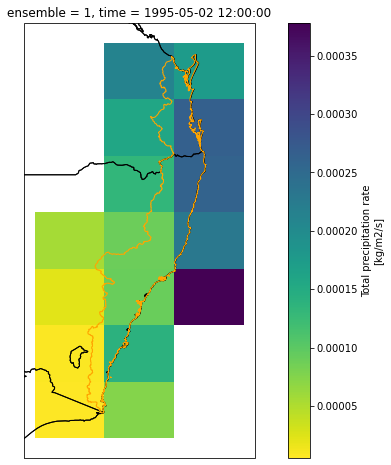

In [22]:
fig = plt.figure(figsize=[12,8])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ds_selection['pr'].isel({'time': 1, 'ensemble': 0}).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='viridis_r',    
)
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)
ax.add_geometries(shapes.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='orange')
#ax.set_extent([140, 160, -20, -40], crs=ccrs.PlateCarree())
plt.show()

## Percentage overlap method

In [11]:
ds_selection = spatial_selection.select_shapefile_regions(
    ds,
    shapefile,
    agg="none",
    method="fraction",
    min_overlap=0.1,
)

> /home/599/dbi599/forks/unseen/unseen/spatial_selection.py(174)select_shapefile_regions()
    172         mask = mask.max("region")
    173     pdb.set_trace()
--> 174     if agg == "none" :
    175         if mask.ndim == 2:
    176             mask = _mask_to_np_bool(mask)

ipdb> c


In [12]:
ds_selection

<xarray.Dataset>
Dimensions:   (time: 3, ensemble: 2, lat: 6, lon: 3)
Coordinates:
  * ensemble  (ensemble) int64 1 2
  * lat       (lat) float64 -35.39 -33.37 -31.35 -29.33 -27.3 -25.28
  * lon       (lon) float64 148.8 151.2 153.8
  * time      (time) object 1995-05-01 12:00:00 ... 1995-05-03 12:00:00
Data variables:
    pr        (time, ensemble, lat, lon) float32 dask.array<chunksize=(3, 2, 6, 3), meta=np.ndarray>
Attributes:
    comment:    pressure level interpolator, version 3.0, precision=double
    filename:   atmos_isobaric_daily.zarr
    grid_tile:  N/A
    grid_type:  regular
    title:      AccessOcean-AM2

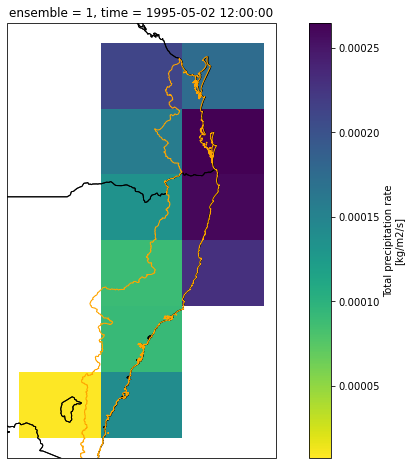

In [13]:
fig = plt.figure(figsize=[12,8])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ds_selection['pr'].isel({'time': 1, 'ensemble': 0}).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='viridis_r',
)
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)
ax.add_geometries(shapes.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='orange')
#ax.set_extent([140, 160, -20, -40], crs=ccrs.PlateCarree())
plt.show()